<a href="https://colab.research.google.com/github/TinkeringEngr/DeepSpeed/blob/master/Copy_of_alphafold_nomsa_notemplates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold

In [ ]:
#################
# WARNING 
#################
# - This notebook is intended as a "quick" demo, it disables many aspects of the full alphafold2 pipeline 
#   (input MSA/templates, amber MD refinement, and ensembling). For best results, we recommend using the
#   full pipeline: https://github.com/deepmind/alphafold
# - That being said, it was found that input templates, amber refinement, and ensembling did not help much.
#   The key input features are the MSA (Multiple Sequence Alignment) of related proteins. Where you see a 
#   significant drop in predicted accuracy when MSA < 30, but only minor improvements > 100. 
# - This notebook does NOT include the MSA generation step, and is designed to work with a single sequence 
#   or custom MSA input (that you can upload).
# - Single sequence mode is particularly useful for denovo designed proteins (where there are no sequence
#   homologs by definition). For natural proteins, an MSA input will make a huge difference.

#################
# EXTRA
#################
# check out RoseTTAFold
# https://colab.research.google.com/drive/1MBht6Nvy2vQCqPSdVg73zbiWZIvt7Zx0

In [ ]:
%%bash
# download model
git clone https://github.com/deepmind/alphafold.git
mv alphafold alphafold_
mv alphafold_/alphafold .

Cloning into 'alphafold'...


In [ ]:
%%bash
# download model params (~1 min)
wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
mkdir params
tar -xf alphafold_params_2021-07-14.tar -C params/
rm alphafold_params_2021-07-14.tar

In [ ]:
%%bash
pip -q install biopython
pip -q install dm-haiku
pip -q install ml-collections
pip -q install mock
pip -q install py3Dmol

In [ ]:
import os
import mock
import numpy as np
import pickle
import py3Dmol
from typing import Dict
import matplotlib.pyplot as plt

In [ ]:
from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.data import templates
from alphafold.model import data
from alphafold.model import config
from alphafold.model import model

In [ ]:
# setup which model params to use (note for demo, we are only using model_1)
model_runners = {}
models = ["model_1"] #,"model_2","model_3","model_4","model_5"]
for model_name in models:
  model_config = config.model_config(model_name)
  model_config.data.eval.num_ensemble = 1
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(model_config, model_params)
  model_runners[model_name] = model_runner

In [ ]:
def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a mock example w/ zero input, confidence -1
  output_templates_sequence = []
  output_confidence_scores = []
  templates_all_atom_positions = []
  templates_all_atom_masks = []

  for _ in query_sequence:
    templates_all_atom_positions.append(np.zeros((templates.residue_constants.atom_type_num, 3)))
    templates_all_atom_masks.append(np.zeros(templates.residue_constants.atom_type_num))
    output_templates_sequence.append('-')
    output_confidence_scores.append(-1)
  output_templates_sequence = ''.join(output_templates_sequence)
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)

  template_features = {'template_all_atom_positions': np.array(templates_all_atom_positions)[None],
        'template_all_atom_masks': np.array(templates_all_atom_masks)[None],
        'template_sequence': [f'none'.encode()],
        'template_aatype': np.array(templates_aatype)[None],
        'template_confidence_scores': np.array(output_confidence_scores)[None],
        'template_domain_names': [f'none'.encode()],
        'template_release_date': [f'none'.encode()]}
        
  return template_features

In [ ]:
def predict_structure(
    prefix: str,
    data_pipeline: pipeline.DataPipeline,
    model_runners: Dict[str, model.RunModel],
    random_seed: int):
  
  """Predicts structure using AlphaFold for the given sequence."""

  # Get features.
  feature_dict = data_pipeline.process()

  # Run the models.
  plddts = {}
  for model_name, model_runner in model_runners.items():
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_path = f'{prefix}_unrelaxed_{model_name}.pdb'
    plddts[model_name] = prediction_result['plddt']

    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(protein.to_pdb(unrelaxed_protein))
  return plddts

# Single sequence input (no MSA, no templates)

In [ ]:
# CHANGE THIS LINE TO SEQUENCE you want to predcit
query_sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE"

In [ ]:
# mock pipeline for testing
data_pipeline_mock = mock.Mock()
data_pipeline_mock.process.return_value = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[[query_sequence]],
                                 deletion_matrices=[[[0]*len(query_sequence)]]),
    **mk_mock_template(query_sequence)
}

In [ ]:
%%time
plddts = predict_structure(
  prefix="test",
  data_pipeline=data_pipeline_mock,
  model_runners=model_runners,
  random_seed=0)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


CPU times: user 2min 18s, sys: 6.73 s, total: 2min 25s
Wall time: 2min 12s


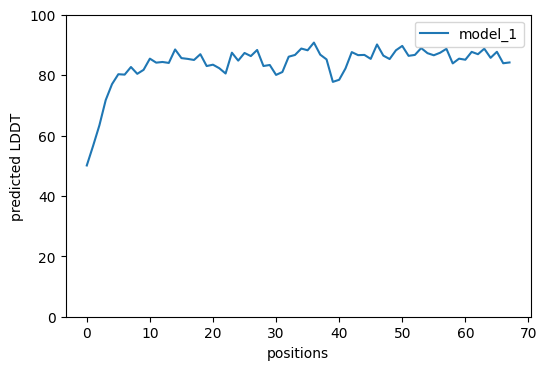

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'},'stick':{}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Custom MSA input
(no templates)

In [ ]:
%%bash
# for this demo we will download a premade MSA input
wget -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A8I3.fas

In [ ]:
a3m_lines = "".join(open("P0A8I3.fas","r").readlines())
msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
query_sequence = msa[0]

In [ ]:
# mock pipeline for testing
data_pipeline_mock = mock.Mock()
data_pipeline_mock.process.return_value = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}

In [ ]:
%%time
plddts = predict_structure(
  prefix="yaaa",
  data_pipeline=data_pipeline_mock,
  model_runners=model_runners,
  random_seed=0)

CPU times: user 3min 1s, sys: 29.5 s, total: 3min 30s
Wall time: 3min 10s


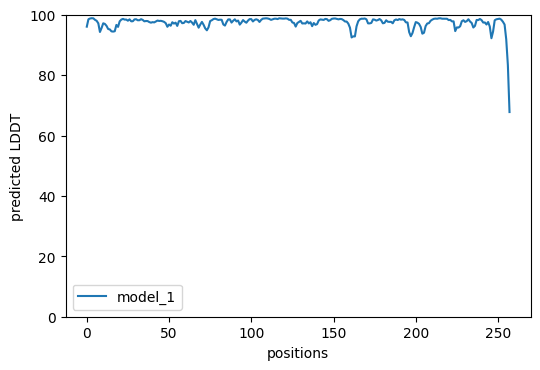

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("yaaa_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
##############################
# Where do I get an MSA?
##############################
# For any "serious" use, I would recommend using the alphafold2 pipeline to make the MSAs, 
# since this is what it was trained on. 


# That being said, part of the MSA generation pipeline (specifically searching against uniprot database using hhblits)
# can be done here: https://toolkit.tuebingen.mpg.de/tools/hhblits
# download the a3m file and upload to the notebook!


# hit "submit" -> wait... -> "Query Template MSA" -> "Download Full A3M"
# upload notebook to google colab (left side, hit the "folder" icon, then hit "upload" icon)
# change this line:
# a3m_lines = "".join(open("YOUR_A3M_FILE.a3m","r").readlines())